<a href="https://colab.research.google.com/github/Nobel712/Image-Segmentation/blob/main/breast_ultrasound_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

 95% 186M/195M [00:02<00:00, 72.3MB/s]
100% 195M/195M [00:02<00:00, 87.3MB/s]


In [ ]:
from zipfile import ZipFile
with ZipFile('/content/breast-ultrasound-images-dataset.zip','r')as zip:
  zip.extractall('/content')

In [ ]:
# import system libs 
import os
import time
import glob
import shutil

# import data handling tools 
import cv2
import PIL
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
import tensorflow.image as tfi
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D,  MaxPool2D, UpSampling2D, Concatenate, Activation,Conv2DTranspose
from tensorflow.keras.layers import Layer, Input, Add, Multiply, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
size=256
num_images=1000


In [ ]:
def create_data(data_dir):
    image_paths = []
    mask_paths = []
    classes = sorted(os.listdir(data_dir))
    
    single_mask_paths = sorted([sorted(glob.glob(data_dir + name + "/*mask.png")) for name in classes])
    double_mask_paths = sorted([sorted(glob.glob(data_dir + name + "/*mask_1.png")) for name in classes])
    
    for class_path in single_mask_paths:
        for path in class_path:
            img_path = path.replace('_mask', '')
            image_paths.append(img_path)
            mask_paths.append(path)
    
    return image_paths, mask_paths

In [ ]:
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image)) / 255., (SIZE, SIZE)), 4)

# function to read multiple images
def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]
    
    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
    
    for i, image in enumerate(image_paths):
        img = load_image(image, SIZE)
        if mask:
            images[i] = img[:, :, :1]
        else:
            images[i] = img
    
    return images

In [ ]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

def show_images(imgs, msks):
    plt.figure(figsize=(13,8))
    
    for i in range(15):
        plt.subplot(3,5,i+1)
        id = np.random.randint(len(imgs))
        show_mask(imgs[id], msks[id], cmap='binary')
    
    plt.tight_layout()
    plt.show()

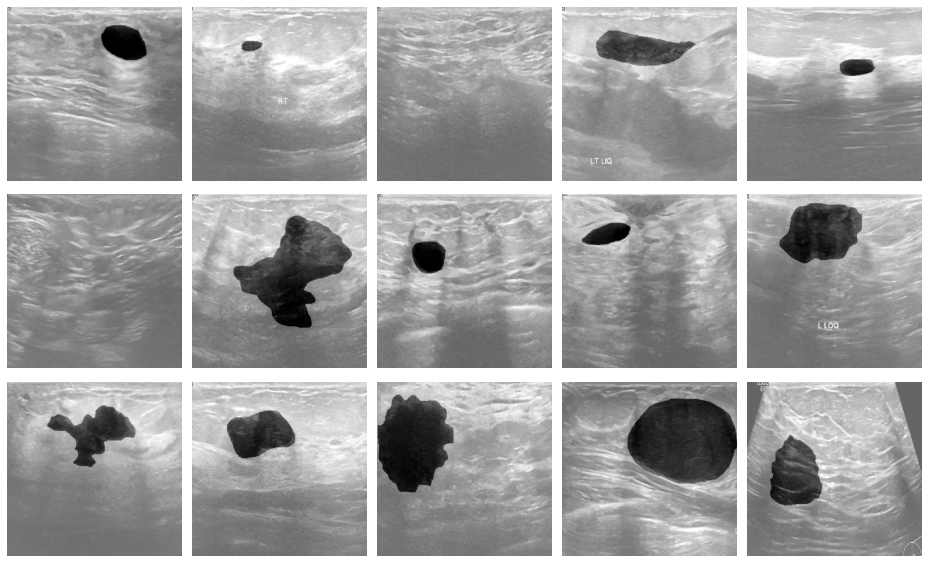

In [ ]:
SIZE = 256
#rgb thake gray korta(img=[cv2.imread(img,0)for img in imgdata])
# get data
data_dir = '/content/Dataset_BUSI_with_GT/'
image_paths, mask_paths = create_data(data_dir)

# load images and masks
imgs = load_images(image_paths, SIZE)
msks = load_images(mask_paths, SIZE, mask=True)

# show sample
show_images(imgs, msks)

In [ ]:
imgs.shape

(780, 256, 256, 3)

In [ ]:
print('Max pixel value in image: ',imgs.max())
print('Label in the mask are : ',np.unique(msks))

Max pixel value in image:  1.0
Label in the mask are :  [0.00000000e+00 9.99999975e-05 1.99999995e-04 ... 9.99800026e-01
 9.99899983e-01 1.00000000e+00]


In [ ]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(imgs,msks,test_size=0.2,random_state=42)

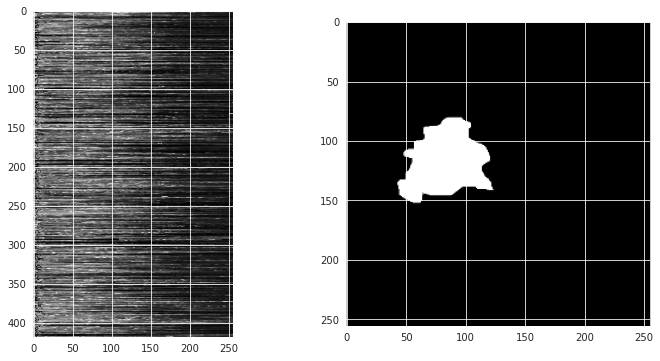

In [ ]:
import random
image_n=random.randint(0,len(xtrain)-1)
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(xtrain[image_n:,:,0],cmap='gray')
plt.subplot(122)
plt.imshow(ytrain[image_n,:,:,0],cmap='gray')
plt.show()


In [ ]:


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


In [ ]:
#building UNet
inputs=Input(imgs.shape[-3:])

s1, p1 = encoder_block(inputs, 64)
s2, p2 = encoder_block(p1, 128)
s3, p3 = encoder_block(p2, 256)
s4, p4 = encoder_block(p3, 512)

b1 = conv_block(p4, 1024) #Bridge

d1 = decoder_block(b1, s4, 512)
d2 = decoder_block(d1, s3, 256)
d3 = decoder_block(d2, s2, 128)
d4 = decoder_block(d3, s1, 64)

outputs = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)
model=Model(inputs,outputs,name='U-Net')
model.compile(optimizer=Adam(learning_rate=1e-3),loss='binary_crossentropy',metrics=['Accuracy'])
model.summary()



Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_50 (Conv2D)             (None, 256, 256, 64  1792        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_50 (BatchN  (None, 256, 256, 64  256        ['conv2d_50[0][0]']              
 ormalization)                  )                                                             

In [ ]:
history=model.fit(xtrain,ytrain,batch_size=16,verbose=1,epochs=25,validation_data=(xtest,ytest),shuffle=False)

Epoch 1/25
39/39 [==============================] - 77s 1s/step - loss: 0.3271 - Accuracy: 0.8966 - val_loss: 730.5964 - val_Accuracy: 0.0903
Epoch 2/25
39/39 [==============================] - 37s 964ms/step - loss: 0.2585 - Accuracy: 0.9244 - val_loss: 117.1106 - val_Accuracy: 0.2213
Epoch 3/25
39/39 [==============================] - 38s 972ms/step - loss: 0.2523 - Accuracy: 0.9251 - val_loss: 7.9390 - val_Accuracy: 0.1689
Epoch 4/25
39/39 [==============================] - 38s 972ms/step - loss: 0.2469 - Accuracy: 0.9261 - val_loss: 0.2790 - val_Accuracy: 0.9225
Epoch 5/25
39/39 [==============================] - 38s 969ms/step - loss: 0.2435 - Accuracy: 0.9250 - val_loss: 1.0912 - val_Accuracy: 0.7105
Epoch 6/25
39/39 [==============================] - 38s 970ms/step - loss: 0.2524 - Accuracy: 0.9240 - val_loss: 4.4406 - val_Accuracy: 0.4114
Epoch 7/25
39/39 [==============================] - 38s 969ms/step - loss: 0.2435 - Accuracy: 0.9266 - val_loss: 0.2537 - val_Accuracy: 0.925